## Import libraries

In [ ]:
import os
import cv2
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
import seaborn as sns  
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from transformers import TFViTModel
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras.layers import Permute, Input, Layer, Flatten, Add, LayerNormalization, MultiHeadAttention, Dense, Embedding, Rescaling, Resizing, RandomFlip, RandomRotation, RandomContrast, RandomBrightness, RandomCrop, RandomTranslation, RandomZoom, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import TopKCategoricalAccuracy, CategoricalAccuracy
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger


2024-03-24 15:11:15.833604: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-24 15:11:15.833706: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-24 15:11:15.960020: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Data preparation

In [ ]:
train_directory = "/kaggle/input/fer2013/train"
test_directory = "/kaggle/input/fer2013/test"
CLASS_NAMES = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

CONFIGURATION = {
    'BATCH_SIZE': 32,
    'IMG_SIZE': 64,
}

In [ ]:
# Create dataframe from directories
def create_dataframe_from_directory(directory):
    file_paths = []
    labels = []
    for label, class_name in enumerate(CLASS_NAMES):
        class_directory = os.path.join(directory, class_name)
        for filename in os.listdir(class_directory):
            file_paths.append(os.path.join(class_directory, filename))
            labels.append(class_name)
    data = {'file_paths': file_paths, 'labels': labels}
    return pd.DataFrame(data)

# Create dataframes
train_df = create_dataframe_from_directory(train_directory)
test_df = create_dataframe_from_directory(test_directory)

In [ ]:
# Plot distribution of labels
plt.figure(figsize=(10, 6))
train_df['labels'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Distribution of Labels in Training Data')
plt.xlabel('Emotion Labels')
plt.ylabel('Count')
plt.xticks(ticks=range(len(CLASS_NAMES)), labels=CLASS_NAMES, rotation=45)
plt.show()

In [ ]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1)
for train_index, validation_index in sss.split(train_df['file_paths'], train_df['labels']):
    train_df, validation_df = train_df.iloc[train_index], train_df.iloc[validation_index]

print("train_df shape: {}".format(train_df.shape))
print("validation_df shape: {}".format(validation_df.shape))

In [ ]:
# Perform Random Oversampling
oversampler = RandomOverSampler()
X_train_resampled, y_train_resampled = oversampler.fit_resample(train_df[['file_paths']], train_df['labels'])

# Convert oversampled data to DataFrame
balanced_labels_df = pd.concat([X_train_resampled, y_train_resampled], axis=1)

In [ ]:
# Plot distribution of labels
plt.figure(figsize=(10, 6))
balanced_labels_df['labels'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Distribution of Labels in Training Data')
plt.xlabel('Emotion Labels')
plt.ylabel('Count')
plt.xticks(ticks=range(len(CLASS_NAMES)), labels=CLASS_NAMES, rotation=45)
plt.show()

In [ ]:
train_datagen = ImageDataGenerator( 
    rescale=1./255,
    rotation_range=5,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_dataset = train_datagen.flow_from_dataframe(
    train_df,
    directory = train_directory,
    x_col = 'file_paths',
    y_col = 'labels',
    class_mode = 'categorical',
    target_size = (CONFIGURATION['IMG_SIZE'], CONFIGURATION['IMG_SIZE']),
    interpolation="bicubic",
    batch_size = CONFIGURATION['BATCH_SIZE'],
    seed=99, ## Always have the same shuffing
    shuffing=True,
)

validation_datagen = ImageDataGenerator(rescale=1./255)

val_dataset = validation_datagen.flow_from_dataframe(
    validation_df,
    directory = train_directory,
    x_col = 'file_paths',
    y_col = 'labels',
    class_mode = 'categorical',
    target_size = (CONFIGURATION['IMG_SIZE'], CONFIGURATION['IMG_SIZE']),
    interpolation="bicubic",
    batch_size = CONFIGURATION['BATCH_SIZE'],
    shuffle=False
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_dataset = validation_datagen.flow_from_dataframe(
    test_df,
    directory = test_directory,
    x_col = 'file_paths',
    y_col = 'labels',
    class_mode = 'categorical',
    target_size = (CONFIGURATION['IMG_SIZE'], CONFIGURATION['IMG_SIZE']),
    interpolation="bicubic",
    batch_size = CONFIGURATION['BATCH_SIZE'],
    shuffle=False
)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_images_from_each_class(dataset, class_names):
    class_batch = {}
    for images, labels in dataset:
        for img, label in zip(images, labels):
            class_index = np.argmax(label)
            class_name = class_names[class_index]
            
            if class_name not in class_batch:
                class_batch[class_name] = img
                if len(class_batch) == len(class_names):
                    break
        if len(class_batch) == len(class_names):
            break
    
    # Plotting
    n = len(class_batch)
    plt.figure(figsize=(10, 2 * n))
    for i, (class_name, image) in enumerate(class_batch.items()):
        plt.subplot(n, 1, i + 1)
        plt.imshow(image)
        plt.title(class_name)
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    
plot_images_from_each_class(train_dataset, CLASS_NAMES)


In [ ]:
import os
import tensorflow as tf

import keras
from keras import layers
from keras import backend

import tensorflow_datasets as tfds

In [ ]:
# Values are from table 4.
patch_size = 4  # 2x2, for the Transformer blocks.
image_size = 64
expansion_factor = 2  # expansion factor for the MobileNetV2 blocks.

In [ ]:
def conv_block(x, filters=16, kernel_size=3, strides=2):
    conv_layer = layers.Conv2D(
        filters,
        kernel_size,
        strides=strides,
        activation=keras.activations.swish,
        padding="same",
    )
    return conv_layer(x)



def correct_pad(inputs, kernel_size):
    img_dim = 2 if backend.image_data_format() == "channels_first" else 1
    input_size = inputs.shape[img_dim : (img_dim + 2)]
    if isinstance(kernel_size, int):
        kernel_size = (kernel_size, kernel_size)
    if input_size[0] is None:
        adjust = (1, 1)
    else:
        adjust = (1 - input_size[0] % 2, 1 - input_size[1] % 2)
    correct = (kernel_size[0] // 2, kernel_size[1] // 2)
    return (
        (correct[0] - adjust[0], correct[0]),
        (correct[1] - adjust[1], correct[1]),
    )



def inverted_residual_block(x, expanded_channels, output_channels, strides=1):
    m = layers.Conv2D(expanded_channels, 1, padding="same", use_bias=False)(x)
    m = layers.BatchNormalization()(m)
    m = keras.activations.swish(m)

    if strides == 2:
        m = layers.ZeroPadding2D(padding=correct_pad(m, 3))(m)
    m = layers.DepthwiseConv2D(
        3, strides=strides, padding="same" if strides == 1 else "valid", use_bias=False
    )(m)
    m = layers.BatchNormalization()(m)
    m = keras.activations.swish(m)

    m = layers.Conv2D(output_channels, 1, padding="same", use_bias=False)(m)
    m = layers.BatchNormalization()(m)

    if keras.ops.equal(x.shape[-1], output_channels) and strides == 1:
        return layers.Add()([m, x])
    return m



def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=keras.activations.swish)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


def transformer_block(x, transformer_layers, projection_dim, num_heads=2):
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(x)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, x])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(
            x3,
            hidden_units=[x.shape[-1] * 2, x.shape[-1]],
            dropout_rate=0.1,
        )
        # Skip connection 2.
        x = layers.Add()([x3, x2])

    return x


def mobilevit_block(x, num_blocks, projection_dim, strides=1):
    local_features = conv_block(x, filters=projection_dim, strides=strides)
    local_features = conv_block(
        local_features, filters=projection_dim, kernel_size=1, strides=strides
    )

    # Unfold into patches and then pass through Transformers.
    num_patches = int((local_features.shape[1] * local_features.shape[2]) / patch_size)
#     print(local_features.shape[1])
#     print(local_features.shape[2])
#     print(patch_size)
#     num_patches = (local_features.shape[1] // patch_size)**2
#     print("***", num_patches)
    non_overlapping_patches = layers.Reshape((patch_size, num_patches, projection_dim))(
        local_features
    )
    global_features = transformer_block(
        non_overlapping_patches, num_blocks, projection_dim
    )

    # Fold into conv-like feature-maps.
    folded_feature_map = layers.Reshape((*local_features.shape[1:-1], projection_dim))(
        global_features
    )

    # Apply point-wise conv -> concatenate with the input features.
    folded_feature_map = conv_block(
        folded_feature_map, filters=x.shape[-1], kernel_size=1, strides=strides
    )
    local_global_features = layers.Concatenate(axis=-1)([x, folded_feature_map])

    # Fuse the local and global features using a convoluion layer.
    local_global_features = conv_block(
        local_global_features, filters=projection_dim, strides=strides
    )

    return local_global_features

In [ ]:
def create_mobilevit(num_classes=5):
    inputs = keras.Input((image_size, image_size, 3))
    x = layers.Rescaling(scale=1.0 / 255)(inputs)

    # Initial conv-stem -> MV2 block.
    x = conv_block(x, filters=16)
    x = inverted_residual_block(
        x, expanded_channels=16 * expansion_factor, output_channels=16
    )

    # Downsampling with MV2 block.
    x = inverted_residual_block(
        x, expanded_channels=16 * expansion_factor, output_channels=24, strides=2
    )
    x = inverted_residual_block(
        x, expanded_channels=24 * expansion_factor, output_channels=24
    )
    x = inverted_residual_block(
        x, expanded_channels=24 * expansion_factor, output_channels=24
    )

    # First MV2 -> MobileViT block.
    x = inverted_residual_block(
        x, expanded_channels=24 * expansion_factor, output_channels=48, strides=2
    )
    x = mobilevit_block(x, num_blocks=2, projection_dim=64)

    # Second MV2 -> MobileViT block.
    x = inverted_residual_block(
        x, expanded_channels=64 * expansion_factor, output_channels=64, strides=2
    )
    x = mobilevit_block(x, num_blocks=4, projection_dim=80)

    # Third MV2 -> MobileViT block.
    x = inverted_residual_block(
        x, expanded_channels=80 * expansion_factor, output_channels=80, strides=2
    )
    x = mobilevit_block(x, num_blocks=3, projection_dim=96)
    x = conv_block(x, filters=320, kernel_size=1, strides=1)

    # Classification head.
    x = layers.GlobalAvgPool2D()(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
#     outputs = layers.Dense(7)(x)

    return keras.Model(inputs, outputs)


mobilevit_xxs = create_mobilevit()
mobilevit_xxs.summary()

In [ ]:
# Compile the model
# mobilevit_xxs.compile(
#     optimizer=Adam(learning_rate=1e-5),  # Set the learning rate
#     loss=CategoricalCrossentropy(from_logits=True),  # Use CategoricalCrossentropy as loss function
#     metrics=[CategoricalAccuracy(), TopKCategoricalAccuracy(k=5)]  # Monitor accuracy and top-5 accuracy
# )


mobilevit_xxs.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.002),  # Set the learning rate
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.1),  # Use CategoricalCrossentropy as loss function
    metrics=["accuracy"]  # Monitor accuracy and top-5 accuracy
)

checkpoint = ModelCheckpoint(
    filepath='/kaggle/working/best_model.keras',  # Adjust the path as necessary
    save_best_only=True)

early_stopping = EarlyStopping(monitor='val_loss',
                          patience=5,
                          verbose=1,
                          restore_best_weights=True
                          )

csv_logger = CSVLogger(f"/kaggle/working/model.log")

history = mobilevit_xxs.fit(
    train_dataset,  #
    validation_data=val_dataset,  
    epochs=30,  
    callbacks=[checkpoint, early_stopping, csv_logger]  #
)


In [ ]:
# Plot training history
# This will help you visualize the training and validation accuracy and loss over epochs.
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Time')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['categorical_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Time')
plt.legend()

plt.show()

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy
from sklearn.metrics import classification_report
import numpy as np
from sklearn.metrics import confusion_matrix

actual_labels = []
predicted_labels = []

for images, labels in test_dataset:
    # Get model predictions
    preds = mobilevit_xxs.predict(images)
    # Convert predictions to label indices
    pred_labels = np.argmax(preds, axis=1)
    actual_labels.extend(np.argmax(labels.numpy(), axis=1))
    predicted_labels.extend(pred_labels)

# Convert lists to numpy arrays for compatibility with sklearn metrics
actual_labels = np.array(actual_labels)
predicted_labels = np.array(predicted_labels)
# Calculate accuracy
accuracy = CategoricalAccuracy()
accuracy.update_state(actual_labels, predicted_labels)
test_accuracy = accuracy.result().numpy()

# Calculate precision, recall, and F1-score
report = classification_report(actual_labels, predicted_labels, target_names=CLASS_NAMES, output_dict=True)

print(classification_report(actual_labels, predicted_labels, target_names=CLASS_NAMES))

# If you want to access individual values, you can do it like this:
for class_name in CLASS_NAMES:
    class_report = report[class_name]
    print(f"Class: {class_name}")
    print(f"Precision: {class_report['precision']}")
    print(f"Recall: {class_report['recall']}")
    print(f"F1-Score: {class_report['f1-score']}")

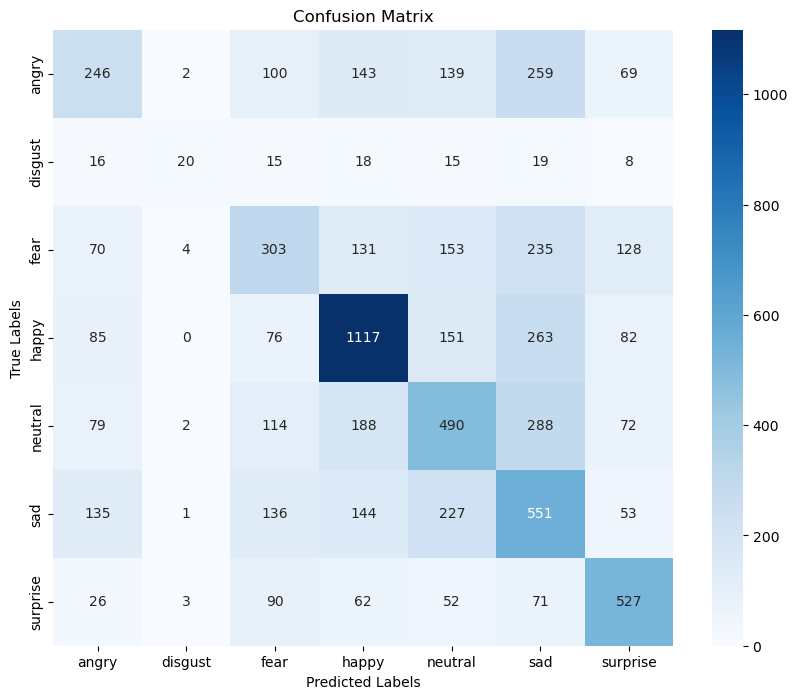

In [17]:

# Calculate the confusion matrix
cm = confusion_matrix(actual_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()